In [1]:
import warnings
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ConstantInputWarning
import os, sys
sys.path.insert(0, "../")
from alphalens.utils import get_forward_returns_columns

from factor_cal.config_loader import basic_config as cfg
from factor_cal.table.ddb_table import PriceTable, SecLevelFacTable
from factor_cal.utils import ddb_utils as du
from factor_cal.factor_eval.basic_evaluate import get_clean_data, factor_portfolio_return,\
    factor_information_coefficient, get_factor_ic_summary_info, plot_quantile_ic, plot_quantile_netvalue
from factor_cal.factor_eval import basic_evaluate as be
# igmore the warning of ConstantInputWarning
warnings.filterwarnings("ignore", category=ConstantInputWarning)
# obtain the ddb session
s = du.DDBSessionSingleton().session   

In [14]:
import pandas as pd

# 创建 MultiIndex
index = pd.MultiIndex.from_tuples([('A', 1), ('A', 2), ('B', 1), ('B', 2), ('C', 1), ('C', 2)], names=['level_1', 'level_2'])

# 创建 Series
s = pd.Series([3, 1, 2, 5, 4, 2], index=index)

print(s)

level_1  level_2
A        1          3
         2          1
B        1          2
         2          5
C        1          4
         2          2
dtype: int64


In [15]:
# 将 Series 转换为 DataFrame，并添加原始索引
df = s.reset_index()
df.columns = ['level_1', 'level_2', 'value']

# 对值进行排序，同时保持原始 MultiIndex 顺序
df_sorted = df.sort_values(by=['value', 'level_1', 'level_2'])

# 恢复为 MultiIndex 的 Series 并设置原始索引
s_sorted = pd.Series(df_sorted['value'].values, index=pd.MultiIndex.from_frame(df_sorted[['level_1', 'level_2']]))

print(s_sorted)

level_1  level_2
A        2          1
B        1          2
C        2          2
A        1          3
C        1          4
B        2          5
dtype: int64


In [2]:
date = '2023.09.22'
base_dirpath = '/home/wangzirui/workspace/data'
factors_df= pd.read_pickle(f'{base_dirpath}/fac_ret_{date}.pkl')
factors_df.set_index(['tradetime', 'securityid'], inplace=True)

In [3]:
config = cfg.BasicConfig('config/config.yml')

stat_date = '2023.09.22'
factor_name = 'ret_v_prod_5min'

In [4]:
sel_cols = factors_df.columns[:3]
sel_cols = np.append(sel_cols, [factor_name])
factor_and_ret = factors_df[sel_cols].copy()
factor_and_ret.rename(columns={factor_name: "factor"}, inplace=True)
factor_and_ret.replace(np.inf, np.nan, inplace=True)

In [7]:
factor_and_ret[~factor_and_ret['factor'].isna()]

1m        3m        5m    factor
tradetime           securityid                                        
2023-09-22 09:31:39 000002.SZ  -0.004522 -0.004522 -0.003768  0.515152
                    000004.SZ  -0.004899 -0.006124 -0.013472  0.484848
                    000006.SZ  -0.006522 -0.006522 -0.006522  0.878788
                    000010.SZ   0.003040  0.009119  0.021277  0.575758
                    000026.SZ  -0.004363 -0.006981 -0.007853  0.181818
...                                  ...       ...       ...       ...
2023-09-22 14:57:00 688777.SH  -0.001059 -0.000847       NaN  0.120000
                    688778.SH  -0.000951 -0.000951       NaN  0.490000
                    688779.SH   0.001127 -0.001127       NaN  0.505000
                    688793.SH  -0.001085 -0.001628       NaN  0.960000
                    688981.SH  -0.001756 -0.000781       NaN  0.500000

[23813479 rows x 4 columns]

In [12]:
factor_and_ret.loc['2023-09-22 09:31:39'][factor_and_ret.loc['2023-09-22 09:31:39', 'factor'].notnull()]

,1m,3m,5m,factor
securityid,,,,
000002.SZ,-0.004522,-0.004522,-0.003768,0.515152
000004.SZ,-0.004899,-0.006124,-0.013472,0.484848
000006.SZ,-0.006522,-0.006522,-0.006522,0.878788
000010.SZ,0.003040,0.009119,0.021277,0.575758
000026.SZ,-0.004363,-0.006981,-0.007853,0.181818
...,...,...,...,...
688036.SH,0.005263,0.012782,0.008647,0.939394
688207.SH,0.001025,0.005635,0.006147,0.030303
688549.SH,0.003850,0.008662,0.003850,0.393939


In [13]:
factor_and_ret.loc['2023-09-22 09:31:42'][factor_and_ret.loc['2023-09-22 09:31:42', 'factor'].notnull()]

,1m,3m,5m,factor
securityid,,,,
000001.SZ,-0.001807,-0.003613,-0.002710,0.090909
000002.SZ,-0.004522,-0.003768,-0.003768,0.514706
000004.SZ,-0.004287,-0.005511,-0.012860,0.602941
000005.SZ,-0.013423,-0.006711,-0.006711,0.530303
000006.SZ,-0.004357,-0.004357,-0.004357,0.088235
...,...,...,...,...
688793.SH,0.001387,-0.006380,-0.004716,0.424242
688798.SH,-0.003616,0.000868,-0.002170,0.606061
688800.SH,0.004751,-0.001583,-0.000528,0.666667


In [5]:
import evaluate
close = evaluate.get_trade_close_bydate(stat_date, config)
td_ret = evaluate.get_trade_return(close)

In [6]:
factor_and_ret = get_clean_data(factor_and_ret, config['evaluation'])

Dropped 2.1% entries from factor data: 2.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 50.0%, not exceeded: OK!


In [38]:
factor_and_ret.head(5)

1m        3m        5m    factor  \
datetime            asset                                               
2023-09-22 09:31:39 000002.SZ -0.004522 -0.004522 -0.003768  0.515152   
                    000004.SZ -0.004899 -0.006124 -0.013472  0.484848   
                    000006.SZ -0.006522 -0.006522 -0.006522  0.878788   
                    000010.SZ  0.003040  0.009119  0.021277  0.575758   
                    000026.SZ -0.004363 -0.006981 -0.007853  0.181818   

                               factor_quantile  
datetime            asset                       
2023-09-22 09:31:39 000002.SZ                3  
                    000004.SZ                3  
                    000006.SZ                5  
                    000010.SZ                4  
                    000026.SZ                1

In [7]:
factor_data = factor_and_ret[['factor', 'factor_quantile']].copy()
factor_data.index = factor_data.index.rename(['tradetime', 'securityid'])
groups = np.sort(factor_data['factor_quantile'].unique())
metric_summary = None
netvalue_summary = None

In [9]:
holding_time = 20
factor_data['group_size'] = factor_data.groupby(['tradetime', 'factor_quantile'])['factor'].transform(lambda x: len(x))
factor_data['wt'] = 1 / factor_data['group_size'] / holding_time

In [11]:
portforlio_weight = be.form_portforlio_weight(factor_data, 1, max(groups), holding_time)

In [12]:
port_weight = portforlio_weight.reset_index()
ret_df = td_ret.reset_index()

In [13]:
last_ts = min(ret_df['tradetime'].max(), port_weight['tradetime'].max())
ages = [pd.Timedelta(i*3, unit='s') for i in np.arange(holding_time+1)]

In [33]:
pos = pd.merge(port_weight, pd.DataFrame({'age': ages}), how='cross')
pos.rename(columns={'tradetime': 'tranche'}, inplace=True)

In [34]:
pos['tradetime'] = pos['age'] + pos['tranche']
pos = pos.drop(pos[pos['tradetime'] > last_ts].index) 

In [35]:
pos = pos.merge(ret_df, on=['tradetime', 'securityid'], how='left')

In [36]:
pos['ret'] = pos['ret'] + 1
pos['cumret'] = pos.groupby(['securityid', 'tranche'])['ret'].cumprod()
pos['expr'] = pos['cumret'] * pos['wt']
pos['pnl'] = pos['expr'] * pos['ret'] / (1 + pos['ret'])
pos.loc[pos['age']==0, 'pnl'] = 0

In [37]:
tranche_info = pos.groupby('tranche')['pnl'].sum().reset_index().rename(columns={'pnl': 'tranche_pnl'})
tranche_info['net_value'] = (1+tranche_info['tranche_pnl']).shift(20)
tranche_info['net_value'].fillna(1, inplace=True)
pos = pos.merge(tranche_info, on=['tranche'], how='left')
pos['correct_pnl'] = pos['pnl'] * pos['net_value']

In [ ]:
pos['pnl'] = pos['expr'] * pos['ret'] / (1 + pos['ret'])

In [ ]:
pos['expr'] = pos['cumret'] * pos['wt']

In [9]:
port_metric_summary, port_netvalue_summary = factor_portfolio_return(factor, td_ret, holding_time=20, long_short=True)

In [61]:
# factor_and_ret.head(1)
# td_ret.head(1)
factor = factor_and_ret[['factor', 'factor_quantile', 'wt']].copy()
factor.index = factor.index.rename(['tradetime', 'securityid'])
# factor = factor_and_ret
factor['group_size'] = factor.groupby(['tradetime', 'factor_quantile'])['factor'].transform(lambda x: len(x))
holding_time = 20
factor['wt'] = 1/factor['group_size'] / holding_time

In [62]:
portforlio_weight = form_portforlio_weight(factor, 1, 5, holding_time)

In [77]:
port_weight = portforlio_weight[:100000].reset_index()
ret_df = td_ret.reset_index()

In [78]:
port_weight.head(1)

,tradetime,securityid,factor,factor_quantile,wt,group_size
0,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50


In [84]:
last_ts = min(ret_df['tradetime'].max(), port_weight['tradetime'].max())
ages = np.arange(holding_time+1)
ages = [pd.Timedelta(i*3, unit='s') for i in ages]

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 00:00:03'),
 Timedelta('0 days 00:00:06'),
 Timedelta('0 days 00:00:09'),
 Timedelta('0 days 00:00:12'),
 Timedelta('0 days 00:00:15'),
 Timedelta('0 days 00:00:18'),
 Timedelta('0 days 00:00:21'),
 Timedelta('0 days 00:00:24'),
 Timedelta('0 days 00:00:27'),
 Timedelta('0 days 00:00:30'),
 Timedelta('0 days 00:00:33'),
 Timedelta('0 days 00:00:36'),
 Timedelta('0 days 00:00:39'),
 Timedelta('0 days 00:00:42'),
 Timedelta('0 days 00:00:45'),
 Timedelta('0 days 00:00:48'),
 Timedelta('0 days 00:00:51'),
 Timedelta('0 days 00:00:54'),
 Timedelta('0 days 00:00:57'),
 Timedelta('0 days 00:01:00')]

In [85]:
pos = pd.merge(port_weight, pd.DataFrame({'age': ages}), how='cross')
pos.rename(columns={'tradetime': 'tranche'}, inplace=True)

In [87]:
pos.head(5)

,tranche,securityid,factor,factor_quantile,wt,group_size,age
0,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50,0 days 00:00:00
1,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50,0 days 00:00:03
2,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50,0 days 00:00:06
3,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50,0 days 00:00:09
4,2023-09-22 09:31:39,000026.SZ,0.181818,1,0.001,50,0 days 00:00:12


In [88]:
# Method1 9.9s
# pos['tradetime'] = pos['age'].transform(lambda x: pd.Timedelta(x*3, unit='s')) + pos['tranche']

#Method 2 
pos['tradetime'] = pos['age'] + pos['tranche']

In [90]:
pos = pos.drop(pos[pos['tradetime'] > last_ts].index) 
pos = pos.merge(ret_df, on=['tradetime', 'securityid'], how='left')
pos['cumret'] = pos.groupby(['securityid', 'tranche'])['ret'].transform(lambda x: np.cumprod(1 + x))
pos['expr'] = pos['cumret'] * pos['wt']
pos['pnl'] = pos['expr'] * pos['ret'] / (1 + pos['ret'])
pos.loc[pos['age']==0, 'pnl'] = 0

In [93]:
tranche_info = pos.groupby('tranche')['pnl'].sum().reset_index().rename(columns={'pnl': 'tranche_pnl'})
tranche_info['net_value'] = (1+tranche_info['tranche_pnl']).shift(20)
tranche_info['net_value'].fillna(1, inplace=True)
pos = pos.merge(tranche_info, on=['tranche'], how='left')
pos['correct_pnl'] = pos['pnl'] * pos['net_value']

In [24]:
groups = np.sort(factor_and_ret['factor_quantile'].unique())
col_name = 'group_'+str(1)

In [14]:
port_metric_summary, port_netvalue_summary = factor_portfolio_return(factor_and_ret, td_ret, holding_time=20, long_short=True)

In [18]:
port_metric_summary['factor_name'] = factor_name
table_dirpath = f'{base_dirpath}/BTtable'
os.makedirs(table_dirpath, exist_ok=True)
port_metric_summary.to_csv(f'{table_dirpath}/{factor_name}_metric.csv')
port_netvalue_summary.to_csv(f'{table_dirpath}/{factor_name}_netvalue.csv')
port_metric_summary

,group,total_ret,mean_ret,std_ret,sharpe_ratio,win_rate,max_draw_down,factor_name
0,group_1,0.050546,0.000209,0.000493,0.424243,0.683301,0.003940,ret_v_prod_5min
0,group_2,-0.029388,-0.000128,0.000468,-0.274139,0.322670,0.029884,ret_v_prod_5min
0,group_3,0.005372,0.000022,0.000437,0.051156,0.513756,0.005453,ret_v_prod_5min
0,group_4,0.058694,0.000243,0.000447,0.544005,0.773299,0.005077,ret_v_prod_5min
0,group_5,-0.001757,-0.000007,0.000488,-0.014741,0.468117,0.007960,ret_v_prod_5min
0,hedge,-0.052302,-0.000227,0.000189,-1.201544,0.079974,0.052302,ret_v_prod_5min


,group_1,group_2,group_3,group_4,group_5,hedge
tradetime,,,,,,
2023-09-22 09:31:39,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2023-09-22 09:31:42,1.000035,1.000012,1.000008,0.999991,0.999980,0.999945
2023-09-22 09:31:45,1.000054,1.000030,1.000010,1.000019,0.999997,0.999943
2023-09-22 09:31:48,1.000097,1.000039,1.000023,1.000041,1.000000,0.999903
2023-09-22 09:31:51,1.000106,1.000047,1.000027,1.000054,1.000005,0.999898
...,...,...,...,...,...,...
2023-09-22 14:54:48,1.050425,0.970603,1.005362,1.058640,0.998272,0.947849
2023-09-22 14:54:51,1.050433,0.970585,1.005346,1.058654,0.998256,0.947824
2023-09-22 14:54:54,1.050523,0.970643,1.005388,1.058710,0.998300,0.947778


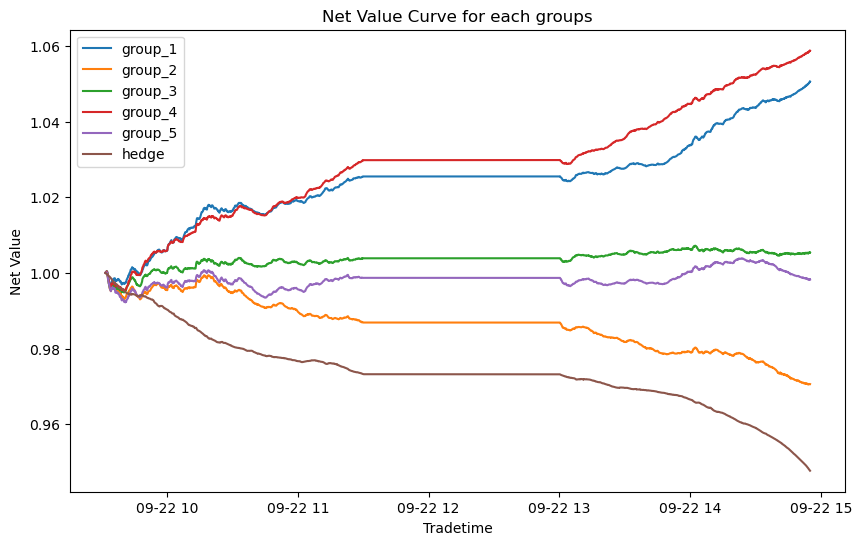

In [19]:
plot_dirpath = f'{base_dirpath}/BTplot'
os.makedirs(plot_dirpath, exist_ok=True)
nv_group_filepath = f"{plot_dirpath}/{factor_name}.png"
plot_quantile_netvalue(port_netvalue_summary, nv_group_filepath)
port_netvalue_summary

In [29]:
names = list(ic_summary_bygroup.index.names)
names[0] = 'Type'
ic_summary_bygroup.index = ic_summary_bygroup.index.rename(names)
ic_summary_bygroup

1m        3m        5m
Type    factor_quantile                              
IC Mean 1                0.042632  0.029070  0.026186
        2               -0.090030 -0.071320 -0.062392
        3                0.035779  0.031591  0.029657
        4                0.114684  0.093502  0.083234
        5               -0.052692 -0.053606 -0.050212
IC Std. 1                0.083101  0.075272  0.072934
        2                0.077972  0.072266  0.071537
        3                0.097391  0.082986  0.075989
        4                0.070258  0.064430  0.062428
        5                0.080355  0.066871  0.065120
ICIR    1                0.513018  0.386200  0.359033
        2               -1.154652 -0.986905 -0.872156
        3                0.367373  0.380681  0.390273
        4                1.632323  1.451223  1.333270
        5               -0.655747 -0.801641 -0.771072

In [30]:
ic_summary_bygroup.loc['IC Mean']

,1m,3m,5m
factor_quantile,,,
1,0.042632,0.029070,0.026186
2,-0.090030,-0.071320,-0.062392
3,0.035779,0.031591,0.029657
4,0.114684,0.093502,0.083234
5,-0.052692,-0.053606,-0.050212


In [24]:
ic_data_bygroup = factor_information_coefficient(factor_and_ret, by_group=True)
ic_summary_bygroup =get_factor_ic_summary_info(ic_data_bygroup, by_group=True)
ic_summary_bygroup

1m        3m        5m
        factor_quantile                              
IC Mean 1                0.042632  0.029070  0.026186
        2               -0.090030 -0.071320 -0.062392
        3                0.035779  0.031591  0.029657
        4                0.114684  0.093502  0.083234
        5               -0.052692 -0.053606 -0.050212
IC Std. 1                0.083101  0.075272  0.072934
        2                0.077972  0.072266  0.071537
        3                0.097391  0.082986  0.075989
        4                0.070258  0.064430  0.062428
        5                0.080355  0.066871  0.065120
ICIR    1                0.513018  0.386200  0.359033
        2               -1.154652 -0.986905 -0.872156
        3                0.367373  0.380681  0.390273
        4                1.632323  1.451223  1.333270
        5               -0.655747 -0.801641 -0.771072

In [67]:
pos['cumret'] = pos.groupby(['securityid', 'tranche'])['ret'].transform(lambda x: np.cumprod(1 + x))
pos['expr'] = pos['cumret'] * pos['wt']
pos['pnl'] = pos['expr'] * pos['ret'] / (1 + pos['ret'])
pos.loc[pos['age']==0, 'pnl'] = 0

In [69]:
pos.head(5)

,tranche,securityid,factor,wt,age,timedelta,tradetime,factor_name,ret,cumret,expr,pnl,tranche_pnl_x,net_value_x,correct_pnl,tranche_pnl_y,net_value_y
0,2023-09-22 09:31:39,000026.SZ,0.181818,0.000962,0,0 days 00:00:00,2023-09-22 09:31:39,haha,-0.000873,0.999127,0.000961,0.000000e+00,0.000019,1.0,0.000000e+00,0.000019,1.0
1,2023-09-22 09:31:39,000026.SZ,0.181818,0.000962,1,0 days 00:00:03,2023-09-22 09:31:42,haha,0.000873,1.000000,0.000962,8.390580e-07,0.000019,1.0,8.390580e-07,0.000019,1.0
2,2023-09-22 09:31:39,000026.SZ,0.181818,0.000962,2,0 days 00:00:06,2023-09-22 09:31:45,haha,0.000000,1.000000,0.000962,0.000000e+00,0.000019,1.0,0.000000e+00,0.000019,1.0
3,2023-09-22 09:31:39,000026.SZ,0.181818,0.000962,3,0 days 00:00:09,2023-09-22 09:31:48,haha,0.000873,1.000873,0.000962,8.390580e-07,0.000019,1.0,8.390580e-07,0.000019,1.0
4,2023-09-22 09:31:39,000026.SZ,0.181818,0.000962,4,0 days 00:00:12,2023-09-22 09:31:51,haha,-0.000872,1.000000,0.000962,-8.390580e-07,0.000019,1.0,-8.390580e-07,0.000019,1.0


In [70]:
tranche_info = pos.groupby('tranche')['pnl'].sum().reset_index().rename(columns={'pnl': 'tranche_pnl'})
tranche_info['net_value'] = (1+tranche_info['tranche_pnl']).shift(20)
tranche_info['net_value'].fillna(1, inplace=True)
pos = pos.merge(tranche_info, on=['tranche'], how='left')
pos['correct_pnl'] = pos['pnl'] * pos['net_value']

In [77]:
from factor_cal.factor_eval.basic_evaluate import calc_portfolio_pnl

In [80]:
a1 = calc_portfolio_pnl(pos, 'group_1')
a2 = calc_portfolio_pnl(pos, 'group_2')

In [85]:
a1_netv = 1+a1['group_1'].cumsum()
a2_netv = 1+a2['group_2'].cumsum()

In [86]:
a1_netv

0     1.000000
1     1.000031
2     1.000053
3     1.000094
4     1.000104
        ...   
63    0.998083
64    0.998067
65    0.998149
66    0.998103
67    0.998090
Name: group_1, Length: 68, dtype: float64

In [87]:
res = a1.merge(a2, how='outer', on='tradetime')

In [32]:
res

NameError: name 'res' is not defined

In [41]:
portforlio_weight = portforlio_weight.loc["2023-09-22 09:31:00":"2023-09-22 09:35:00"]
portforlio_weight

factor        wt
tradetime           securityid                    
2023-09-22 09:31:39 000026.SZ   0.181818  0.000962
                    000158.SZ   0.242424  0.000962
                    000415.SZ   0.030303  0.000962
                    000536.SZ   0.030303  0.000962
                    000969.SZ   0.272727  0.000962
...                                  ...       ...
2023-09-22 09:35:00 688739.SH   0.121212  0.000049
                    688768.SH   0.080808  0.000049
                    688787.SH   0.454545  0.000049
                    688788.SH   0.030928  0.000049
                    688799.SH   0.226804  0.000049

[67642 rows x 2 columns]

In [81]:
import importlib
importlib.reload(evaluate)

<module 'evaluate' from '/home/wangzirui/workspace/CalculateFactor_ByDDBAPI/example/evaluate.py'>

In [65]:
stock_pnl = evaluate.calc_stock_pnl(portforlio_weight, td_ret, holding_time)


UnboundLocalError: local variable 'pos' referenced before assignment

In [64]:
stock_pnl

NameError: name 'stock_pnl' is not defined

In [66]:
portforlio_pnl = evaluate.calc_portfolio_pnl(stock_pnl, 'group_'+str(group_i))
# metric_info = evaluate_pnl(portforlio_pnl)
# metric_summary = pd.concat([metric_summary, metric_info])

In [63]:
portforlio_pnl

NameError: name 'portforlio_pnl' is not defined

In [72]:
metric_info = evaluate.evaluate_pnl(portforlio_pnl, 'group_'+str(group_i))

In [73]:
metric_info

,group,total_ret,mean_ret,std_ret,sharpe_ratio,win_rate,max_draw_down
0,group_1,-0.001788,-0.00109,0.001406,-0.775119,0.176471,0.003781


In [30]:
portforlio_weight

factor        wt
tradetime           securityid                    
2023-09-22 09:31:39 000026.SZ   0.181818  0.000962
                    000158.SZ   0.242424  0.000962
                    000415.SZ   0.030303  0.000962
                    000536.SZ   0.030303  0.000962
                    000969.SZ   0.272727  0.000962
...                                  ...       ...
2023-09-22 14:57:00 688671.SH   0.080000  0.000065
                    688702.SH   0.380000  0.000065
                    688766.SH   0.460000  0.000065
                    688768.SH   0.020000  0.000065
                    688777.SH   0.120000  0.000065

[4758953 rows x 2 columns]

In [64]:
import warnings
import alphalens
import pandas as pd
from scipy import stats
from scipy.stats import ConstantInputWarning
import sys
sys.path.insert(0, "../")
from alphalens import performance as perf
import dolphindb as ddb 

from factor_cal.config_loader import basic_config as cfg
from factor_cal.table.ddb_table import PriceTable, SecLevelFacTable
from factor_cal.utils import ddb_utils as du


# 忽略特定类别的警告
warnings.filterwarnings("ignore", category=ConstantInputWarning)

# read config file
config = cfg.BasicConfig('config/config.yml')
factor_name = "pv_corr"
# obtain the ddb session
s = du.DDBSessionSingleton().session


In [65]:
def get_clean_data(factor_name, date):
    fac_tb = SecLevelFacTable(config['factor_dbPath'], config['factor_tbName'])
    fac = fac_tb.load_factor(factor_name, date, config['start_time'], config['end_time'], sec_list=None)
    
    price_info = config['price_info']
    pc_tb = PriceTable(price_info['price_dbPath'], price_info['price_tbName'], price_info['time_col'], price_info['sec_col'], price_info['price_cols'])
    price = pc_tb.load_price(date, config['start_time'], config['end_time'], sec_list=None)
    
    fac_df = s.loadTable(tableName=fac).toDF()
    if (fac_df.empty):
        return None
    price_df = s.loadTable(tableName=price).toDF()
    
    fac_df = fac_df.set_index(['tradetime', 'securityid'])
    fac_df = fac_df['value']
    fac_df = fac_df.sort_index(level=0)
    
    price_df = price_df.set_index(['tradetime', 'securityid'])
    prices = price_df['close'].unstack()
    
    data=alphalens.utils.get_clean_factor_and_forward_returns(
        fac_df, prices, quantiles=5,periods=(20,60,100))
    return data

In [66]:
data3 = get_clean_data(factor_name, '2023.09.22')


Dropped 30.7% entries from factor data: 30.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [107]:
data3.tail(10)

1m        3m        5m    factor  \
date                asset                                               
2023-09-22 14:55:00 688778.SH  0.000713 -0.001189 -0.001189  0.028065   
                    688779.SH  0.001129  0.001129  0.001129 -0.194700   
                    688788.SH -0.001315 -0.001578 -0.001578  0.218218   
                    688789.SH  0.000659  0.000000  0.000000  0.079354   
                    688798.SH  0.000435  0.002322  0.002322  0.068970   
                    688799.SH  0.001240  0.001240  0.001240 -0.316630   
                    688800.SH  0.000000 -0.000509 -0.000509 -0.509175   
                    688819.SH  0.000286  0.000859  0.000859  0.171618   
                    688981.SH  0.000000  0.000586  0.000586 -0.699929   
                    689009.SH  0.000856  0.000571  0.000571  0.271901   

                               factor_quantile  
date                asset                       
2023-09-22 14:55:00 688778.SH                3  
                    688779.SH                2  
                    688788.SH                4  
                    688789.SH                3  
                    688798.SH                3  
                    688799.SH                2  
                    688800.SH                1  
                    688819.SH                4  
                    688981.SH                1  
                    689009.SH                4

In [74]:
data = data3.rename(columns={'factor_quantile':'group'})
data

1m        3m        5m    factor  group
date                asset                                                   
2023-09-22 09:30:12 000002.SZ  0.000755 -0.002264 -0.002264  0.714826      5
                    000004.SZ  0.005518 -0.006131 -0.006744 -0.199991      2
                    000006.SZ -0.004367 -0.002183 -0.002183 -0.985586      1
                    000010.SZ -0.006061  0.012121  0.015152 -0.011458      3
                    000026.SZ  0.003506 -0.001753 -0.001753 -0.776636      1
...                                 ...       ...       ...       ...    ...
2023-09-22 14:55:00 688799.SH  0.001240  0.001240  0.001240 -0.316630      2
                    688800.SH  0.000000 -0.000509 -0.000509 -0.509175      1
                    688819.SH  0.000286  0.000859  0.000859  0.171618      4
                    688981.SH  0.000000  0.000586  0.000586 -0.699929      1
                    689009.SH  0.000856  0.000571  0.000571  0.271901      4

[16827626 rows x 5 columns]

In [77]:
alphalens.performance.factor_information_coefficient(data, by_group=False)

,1m,3m,5m
date,,,
2023-09-22 09:30:12,-0.032108,-0.033521,-0.018338
2023-09-22 09:30:15,0.009120,-0.020407,-0.005716
2023-09-22 09:30:18,0.002658,0.004670,0.010197
2023-09-22 09:30:21,0.009715,0.022710,0.024852
2023-09-22 09:30:24,0.027744,0.046368,0.044983
...,...,...,...
2023-09-22 14:54:48,0.000049,-0.017524,-0.017524
2023-09-22 14:54:51,0.001268,-0.019766,-0.019766
2023-09-22 14:54:54,-0.014018,-0.014151,-0.014151


In [81]:
data

1m        3m        5m    factor  group
date                asset                                                   
2023-09-22 09:30:12 000002.SZ  0.000755 -0.002264 -0.002264  0.714826      5
                    000004.SZ  0.005518 -0.006131 -0.006744 -0.199991      2
                    000006.SZ -0.004367 -0.002183 -0.002183 -0.985586      1
                    000010.SZ -0.006061  0.012121  0.015152 -0.011458      3
                    000026.SZ  0.003506 -0.001753 -0.001753 -0.776636      1
...                                 ...       ...       ...       ...    ...
2023-09-22 14:55:00 688799.SH  0.001240  0.001240  0.001240 -0.316630      2
                    688800.SH  0.000000 -0.000509 -0.000509 -0.509175      1
                    688819.SH  0.000286  0.000859  0.000859  0.171618      4
                    688981.SH  0.000000  0.000586  0.000586 -0.699929      1
                    689009.SH  0.000856  0.000571  0.000571  0.271901      4

[16827626 rows x 5 columns]

In [89]:
tmp_data = data[:10000]
grouper = [tmp_data.index.get_level_values('date')]
grouper.append('group')
tmp_data.groupby(grouper).apply(lambda x: print("xixi", x))

xixi                                      1m        3m        5m    factor  group
date                asset                                                   
2023-09-22 09:30:12 000006.SZ -0.004367 -0.002183 -0.002183 -0.985586      1
                    000026.SZ  0.003506 -0.001753 -0.001753 -0.776636      1
                    000506.SZ -0.008214 -0.008214 -0.012320 -0.666927      1
                    000584.SZ -0.004264  0.006397  0.014925 -0.468153      1
                    000637.SZ  0.002558 -0.007673  0.000000 -0.839929      1
                    000650.SZ  0.002903 -0.004354 -0.007257 -0.718229      1
                    000826.SZ -0.005479 -0.024658 -0.016438 -0.561431      1
                    001311.SZ  0.000198  0.001191 -0.001191 -0.440686      1
                    002038.SZ -0.003247 -0.008658 -0.011905 -0.432917      1
                    002050.SZ -0.001816 -0.000363  0.000363 -0.722081      1
                    002262.SZ -0.022214 -0.043688 -0.045909 -0.638083  

""


In [99]:
def myfunc(x):
    return x.mean()

In [106]:
# ic_quantile_summary = result.groupby(result.index.get_level_values('group')).apply(lambda x: myfunc(x))
ic_quantile_summary = result.groupby(result.index.get_level_values('group')).agg('mean')
ic_quantile_summary

,1m,3m,5m
group,,,
1,0.005821,0.003325,0.001434
2,0.002137,-0.000060,-0.000023
3,-0.021638,-0.019840,-0.016788
4,0.003562,0.000090,0.000033
5,0.014902,0.008498,0.006812


<Axes: title={'center': 'Mean Period Wise Return By Factor Quantile'}, ylabel='Mean Return (bps)'>

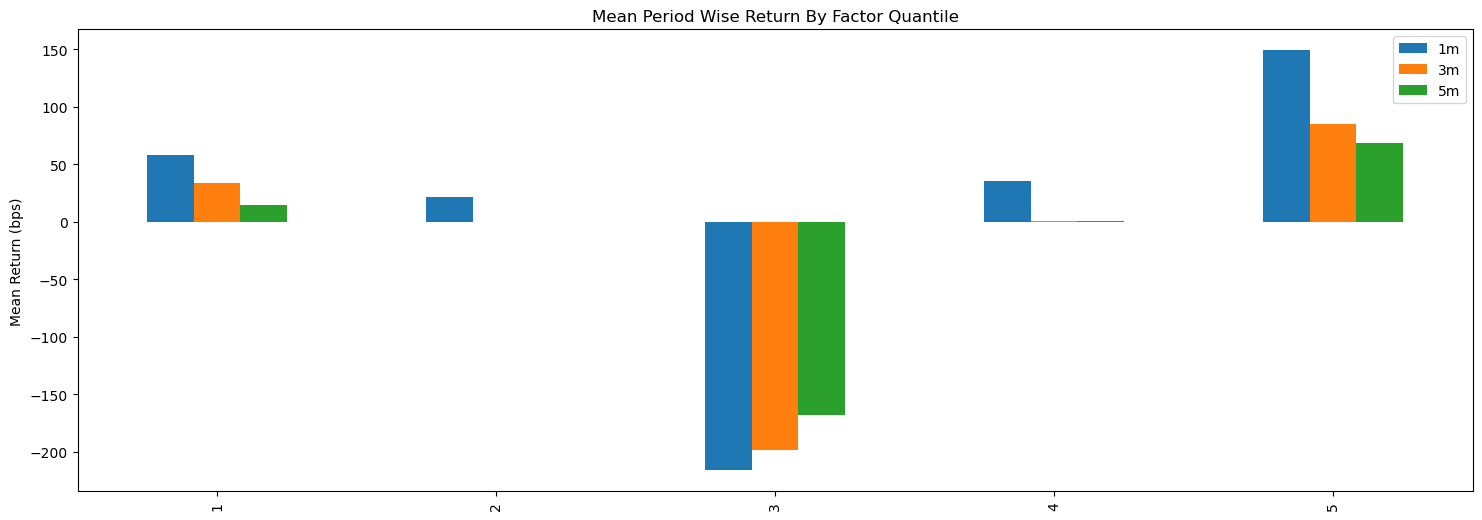

In [103]:
alphalens.plotting.plot_quantile_returns_bar(ic_quantile_summary)

In [94]:
result = alphalens.performance.factor_information_coefficient(data, by_group=True)